# Setting up Imports and Connecting to AWS EC2 Instance

In [ ]:
# necessary installations for the first time 
!pip install tensorflow 
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install opencv-python


!pip install timm
!pip install transformers
!pip install albumentations
!pip install tensorflow
!pip install opencv-python-headless==4.5.2.52
!pip install nltk

     |████████████████████████████████| 462 kB 7.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     |████████████████████████████████| 431 kB 8.3 MB/s 
     |████████████████████████████████| 4.0 MB 7.5 MB/s 
     |████████████████████████████████| 895 kB 69.2 MB/s 
     |████████████████████████████████| 77 kB 7.4 MB/s 
     |████████████████████████████████| 596 kB 76.1 MB/s 
     |████████████████████████████████| 6.6 MB 83.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 631 kB 8.2 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=c8ea7c900ddfd1dd01b95caa3c4d95a90b72b10aab1617a7f0d1cc010e857d13
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: i

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download and unzip dataset from scratch
# takes 20 minutes

! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c h-and-m-personalized-fashion-recommendations
! unzip -q h-and-m-personalized-fashion-recommendations.zip -d .

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 28.7G/28.7G [02:38<00:00, 262MB/s]
100% 28.7G/28.7G [02:38<00:00, 194MB/s]


In [ ]:
import torch
import pandas as pd 
import numpy as np 
import os
import cv2
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import albumentations as alb
from tqdm.autonotebook import tqdm
import itertools
import seaborn as sns
from numpy import savetxt, loadtxt

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         167G   41G  127G  25% /
tmpfs            64M     0   64M   0% /dev
shm              13G     0   13G   0% /dev/shm
/dev/root       2.0G  1.2G  817M  59% /sbin/docker-init
/dev/sda1       174G   44G  130G  25% /opt/bin/.nvidia
tmpfs            13G   32K   13G   1% /var/colab
tmpfs            13G     0   13G   0% /proc/acpi
tmpfs            13G     0   13G   0% /proc/scsi
tmpfs            13G     0   13G   0% /sys/firmware
drive            15G  3.8G   12G  25% /content/drive


In [ ]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

# Data Configs


In [ ]:
class Config:
  # base = '/content/drive/MyDrive/CIS522_Project/'
  base = ''
  debug = False

  # we want batch size to be as big as possible for contrastive loss
  # OpenAI uses 32768 but we can only use 128 due to RAM constraints 
  batch_size = 128

  num_workers = 2
  head_lr = 1e-3
  image_encoder_lr = 1e-4
  text_encoder_lr = 1e-5

  # weight decay is .2 in CLIP Paper
  weight_decay = 0.2

  # we use a different LR, namely decrease on Plateau 
  # Decrease LR after 1 epoch with no improvement 
  patience = 1
  factor = 0.8

  # CLIP paper did 32 epochs
  # because of our compute we can only realistically do 10 epochs 
  # takes about 20 minutes per epoch using AWS EC2 p3.2xlarge instance
  # total runtime of about 4 hours to train the model 
  epochs = 8
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


  model_name = 'resnet50'
  image_embedding = 2048
  base_image_embedding = 64

  # original text encoder was transformer
  text_encoder_model = "distilbert-base-uncased"
  text_embedding = 768
  base_text_embedding = 300
  text_tokenizer = "distilbert-base-uncased"
  max_length = 50

  pretrained = True # for both image encoder and text encoder
  trainable = True # for both image encoder and text encoder
  temperature = 1.0

  # CLIP used 224, have to use 112 for computational advantages
  image_size = 112

  # for projection head; used for both image and text encoders
  num_projection_layers = 1
  projection_dim = 256 
  dropout = 0.3

# Loading and Feature Engineering Text Data for Clothing

In [ ]:
#customers = pd.read_csv(base + 'customers.csv')
#transactions = pd.read_csv(base + 'transactions_train.csv')
articles = pd.read_csv(Config.base + 'articles.csv')
articles = articles.set_index(['article_id'])
articles.loc[articles.index == 108775015, 'detail_desc']

article_id
108775015    Jersey top with narrow shoulder straps.
Name: detail_desc, dtype: object

In [ ]:
articles.head()

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


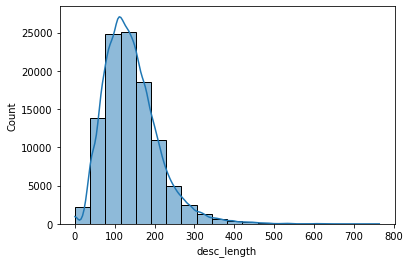

In [ ]:
def length(x):
  if type(x) == float:
    return 0 
  else:
    return len(x)

articles['desc_length'] = articles['detail_desc'].apply(length)
sns.histplot(articles, x='desc_length', bins=20, kde=True)

In [ ]:
articles.columns

Index(['product_code', 'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc', 'desc_length'],
      dtype='object')

In [ ]:
#Extract natural language columns
articles_nlp = articles[['prod_name','product_type_name','product_group_name','graphical_appearance_name','colour_group_name','perceived_colour_value_name','perceived_colour_master_name','department_name','index_name','index_group_name','section_name','garment_group_name', 'detail_desc']]

In [ ]:
articles_nlp.head()

,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,
108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
110065001,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
110065002,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [ ]:
articles['product_type_name'].unique()
#Maybe filter out non-clothing? Like stain remover spray?

array(['Vest top', 'Bra', 'Underwear Tights', 'Socks', 'Leggings/Tights',
       'Sweater', 'Top', 'Trousers', 'Hair clip', 'Umbrella',
       'Pyjama jumpsuit/playsuit', 'Bodysuit', 'Hair string', 'Unknown',
       'Hoodie', 'Sleep Bag', 'Hair/alice band', 'Belt', 'Boots',
       'Bikini top', 'Swimwear bottom', 'Underwear bottom', 'Swimsuit',
       'Skirt', 'T-shirt', 'Dress', 'Hat/beanie', 'Kids Underwear top',
       'Shorts', 'Shirt', 'Cap/peaked', 'Pyjama set', 'Sneakers',
       'Sunglasses', 'Cardigan', 'Gloves', 'Earring', 'Bag', 'Blazer',
       'Other shoe', 'Jumpsuit/Playsuit', 'Sandals', 'Jacket', 'Costumes',
       'Robe', 'Scarf', 'Coat', 'Other accessories', 'Polo shirt',
       'Slippers', 'Night gown', 'Alice band', 'Straw hat', 'Hat/brim',
       'Tailored Waistcoat', 'Necklace', 'Ballerinas', 'Tie',
       'Pyjama bottom', 'Felt hat', 'Bracelet', 'Blouse',
       'Outdoor overall', 'Watch', 'Underwear body', 'Beanie', 'Giftbox',
       'Sleeping sack', 'Dungarees',

In [ ]:
articles_nlp[articles_nlp['product_type_name']=='Unknown']

,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,
156224002,Box 4p Socks,Unknown,Unknown,Solid,Black,Dark,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,Semi-matte socks with a short shaft. 20 denier.
473954008,OP Cheeky hipster 2p,Unknown,Unknown,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre hipster briefs with a low waist, li..."
473954013,OP Cheeky hipster 2p,Unknown,Unknown,Solid,Light Beige,Dusty Light,Beige,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre hipster briefs with a low waist, li..."
473954014,OP Cheeky hipster 2p,Unknown,Unknown,Solid,Yellowish Brown,Medium Dusty,Brown,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre hipster briefs with a low waist, li..."
473954015,OP Cheeky hipster 2p,Unknown,Unknown,Solid,Yellowish Brown,Dark,Brown,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre hipster briefs with a low waist, li..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
925139001,Ruben set,Unknown,Unknown,Solid,Black,Dark,Black,Other items,Ladies Accessories,Ladieswear,Womens Small accessories,Accessories,Set with a matching iPhone case and protective...
925139002,Ruben set,Unknown,Unknown,Solid,Light Pink,Dusty Light,Pink,Other items,Ladies Accessories,Ladieswear,Womens Small accessories,Accessories,Set with a matching iPhone case and protective...
925139003,Ruben set,Unknown,Unknown,Solid,Light Purple,Dusty Light,Lilac Purple,Other items,Ladies Accessories,Ladieswear,Womens Small accessories,Accessories,Set with a matching iPhone case and protective...


In [ ]:
articles['graphical_appearance_name'].unique()

array(['Solid', 'Stripe', 'All over pattern', 'Melange', 'Transparent',
       'Metallic', 'Application/3D', 'Denim', 'Colour blocking', 'Dot',
       'Other structure', 'Contrast', 'Treatment', 'Check', 'Chambray',
       'Front print', 'Glittering/Metallic', 'Mixed solid/pattern',
       'Placement print', 'Other pattern', 'Neps', 'Embroidery', 'Lace',
       'Jacquard', 'Unknown', 'Argyle', 'Slub', 'Mesh', 'Sequin',
       'Hologram'], dtype=object)

In [ ]:
articles['colour_group_name'].unique()

array(['Black', 'White', 'Off White', 'Light Beige', 'Beige', 'Grey',
       'Light Blue', 'Light Grey', 'Dark Blue', 'Dark Grey', 'Pink',
       'Dark Red', 'Greyish Beige', 'Light Orange', 'Silver', 'Gold',
       'Light Pink', 'Dark Pink', 'Yellowish Brown', 'Blue',
       'Light Turquoise', 'Yellow', 'Greenish Khaki', 'Dark Yellow',
       'Other Pink', 'Dark Purple', 'Red', 'Transparent', 'Dark Green',
       'Other Red', 'Turquoise', 'Dark Orange', 'Other', 'Orange',
       'Dark Beige', 'Other Yellow', 'Light Green', 'Other Orange',
       'Purple', 'Light Red', 'Light Yellow', 'Green', 'Light Purple',
       'Dark Turquoise', 'Other Purple', 'Bronze/Copper',
       'Other Turquoise', 'Other Green', 'Other Blue', 'Unknown'],
      dtype=object)

In [ ]:
articles['perceived_colour_value_name'].unique()

array(['Dark', 'Light', 'Dusty Light', 'Medium Dusty', 'Bright', 'Medium',
       'Undefined', 'Unknown'], dtype=object)

In [ ]:
articles['index_name'].unique()

array(['Ladieswear', 'Lingeries/Tights', 'Baby Sizes 50-98', 'Menswear',
       'Ladies Accessories', 'Sport', 'Children Sizes 92-140', 'Divided',
       'Children Sizes 134-170', 'Children Accessories, Swimwear'],
      dtype=object)

In [ ]:
articles['index_group_name'].unique()

array(['Ladieswear', 'Baby/Children', 'Menswear', 'Sport', 'Divided'],
      dtype=object)

In [ ]:
articles['section_name'].unique()

array(['Womens Everyday Basics', 'Womens Lingerie',
       'Womens Nightwear, Socks & Tigh', 'Baby Essentials & Complements',
       'Men Underwear', 'Mama', 'Womens Small accessories',
       'Men H&M Sport', 'Kids Boy', 'Divided Basics',
       'Girls Underwear & Basics', 'Mens Outerwear',
       'Womens Big accessories', 'Divided Accessories',
       'Womens Swimwear, beachwear', 'Divided Selected',
       'Boys Underwear & Basics', 'Contemporary Street',
       'Contemporary Casual', 'Men Accessories', 'Men Suits & Tailoring',
       'Womens Everyday Collection', 'Men Shoes', 'Young Boy', 'H&M+',
       'Divided Collection', 'Ladies Denim', 'Contemporary Smart',
       'Womens Trend', 'Kids Outerwear', 'Young Girl', 'Womens Shoes',
       'Womens Tailoring', 'Divided Projects', 'Denim Men', 'Men Other',
       'Womens Jackets', 'Men Other 2', 'Baby Boy', 'Womens Casual',
       'Kids Accessories, Swimwear & D', 'Ladies H&M Sport',
       'Kids & Baby Shoes', 'Baby Girl', 'Kids Girl

In [ ]:
articles['garment_group_name'].unique()

array(['Jersey Basic', 'Under-, Nightwear', 'Socks and Tights',
       'Jersey Fancy', 'Accessories', 'Trousers Denim', 'Outdoor',
       'Shoes', 'Swimwear', 'Knitwear', 'Shirts', 'Trousers', 'Dressed',
       'Shorts', 'Dresses Ladies', 'Skirts', 'Special Offers', 'Blouses',
       'Unknown', 'Woven/Jersey/Knitted mix Baby', 'Dresses/Skirts girls'],
      dtype=object)

In [ ]:
index_group_to_nlp = {'Ladieswear':"women", 'Baby/Children':'children', 'Menswear':'men', 'Sport':'sport', 'Divided':'all genders'}

In [ ]:
articles_nlp['index_group_name']=articles_nlp['index_group_name'].apply(lambda x: index_group_to_nlp[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
desc_format = "A picture of a {0}, a {12} It is a {1}, which is a {2} for {9}. It is {6} with a {5} pattern."
articles_nlp['long_description'] = [desc_format.format(*r) for r in articles_nlp.values.tolist()]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
articles_nlp["long_description"][108775015]

'A picture of a Strap top, a Jersey top with narrow shoulder straps. It is a Vest top, which is a Garment Upper body for women. It is Black with a Dark pattern.'

In [ ]:
articles["long_description"] = articles_nlp["long_description"]

In [ ]:
articles

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,desc_length,long_description
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,...,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,39,"A picture of a Strap top, a Jersey top with na..."
108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,...,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,39,"A picture of a Strap top, a Jersey top with na..."
108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,...,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,39,"A picture of a Strap top (1), a Jersey top wit..."
110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,...,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",240,"A picture of a OP T-shirt (Idro), a Microfibre..."
110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,...,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",240,"A picture of a OP T-shirt (Idro), a Microfibre..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953450001,953450,5pk regular Placement1,302,Socks,Socks & Tights,1010014,Placement print,9,Black,4,...,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,Socks in a fine-knit cotton blend with a small...,85,"A picture of a 5pk regular Placement1, a Socks..."
953763001,953763,SPORT Malaga tank,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,...,Ladieswear,1,Ladieswear,2,H&M+,1005,Jersey Fancy,Loose-fitting sports vest top in ribbed fast-d...,133,"A picture of a SPORT Malaga tank, a Loose-fitt..."
956217002,956217,Cartwheel dress,265,Dress,Garment Full body,1010016,Solid,9,Black,4,...,Ladieswear,1,Ladieswear,18,Womens Trend,1005,Jersey Fancy,"Short, A-line dress in jersey with a round nec...",172,"A picture of a Cartwheel dress, a Short, A-lin..."


# Creating Custom Dataset Class and DataLoader Object


In [ ]:
# Helper functions for creating data loader object 
def find_classes(directory):
    """Find the class folders in a dataset structured as follows::

            directory/
            ├── class_x
            │   ├── xxx.ext
            │   ├── xxy.ext
            │   └── ...
            │       └── xxz.ext
            └── class_y
                ├── 123.ext
                ├── nsdf3.ext
                └── ...
                └── asd932_.ext

        This method can be overridden to only consider
        a subset of classes, or to adapt to a different dataset directory structure.

        Args:
            directory(str): Root directory path, corresponding to ``self.root``

        Raises:
            FileNotFoundError: If ``dir`` has no class folders.

        Returns:
            (Tuple[List[str], Dict[str, int]]): List of all classes and dictionary mapping each class to an index.
        """
    directory = os.path.expanduser(directory)
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

def make_dataset(directory):
  # loads articles dataframe to get image descriptions from 
  articles = pd.read_csv(Config.base + 'articles.csv')

  # sets the primary index as the article id for optimized speed gains 
  articles = articles.set_index(['article_id'])
  articles["long_description"] = articles_nlp["long_description"]
  extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']
  images, captions = [], []
  _, class_to_idx = find_classes(directory)

  for target_class in sorted(class_to_idx.keys()):
      # class idx is supposed to be the class but we will redo this later 
      class_index = class_to_idx[target_class]
      target_dir = os.path.join(directory, target_class)
      if not os.path.isdir(target_dir):
          continue
      for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
          for fname in sorted(fnames):
              # get image path
              path = os.path.join(root, fname)

              # get text article id
              article_id = fname.split('.')[0]
              description = articles.loc[articles.index == int(article_id), "long_description"].values[0]

              # only add data if there exists a description i.e not empty
              if type(description) == str:
                captions.append(description)
                images.append(path)

  return images, captions 

# Resizes the data and Normalizes the data
def get_transforms(train=True):

  # Can potentially change the transformation function given training/validation data 
  if train:
        return alb.Compose(
            [
                alb.Resize(Config.image_size, Config.image_size, always_apply=True),
                alb.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
  else:
        return alb.Compose(
            [
                alb.Resize(Config.image_size, Config.image_size, always_apply=True),
                alb.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [ ]:
class HMDataset(torch.utils.data.Dataset):
  def __init__(self, root, tokenizer, transforms):
    """
    There is a one to one correspondance between images and text.
    """
    self.images, self.captions = make_dataset(root)

    # tokenize the captions 
    self.encoded_captions = tokenizer(
            list(self.captions), padding=True, truncation=True, max_length=Config.max_length
        ) 

    self.transforms = transforms 

  def __getitem__(self, index):
    item = {
            key: torch.tensor(values[index])
            for key, values in self.encoded_captions.items()
        }

    image = self.images[index]
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      
    image = self.transforms(image=image)['image']
    item['image'] = torch.tensor(image).permute(2, 0, 1).float()
    item['caption'] = self.captions[index]

    return item 

  def __len__(self):
    return len(self.images)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(Config.text_tokenizer)
transforms = get_transforms()
dataset = HMDataset(
        Config.base + 'images/',
        tokenizer=tokenizer,
        transforms=transforms
    )

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


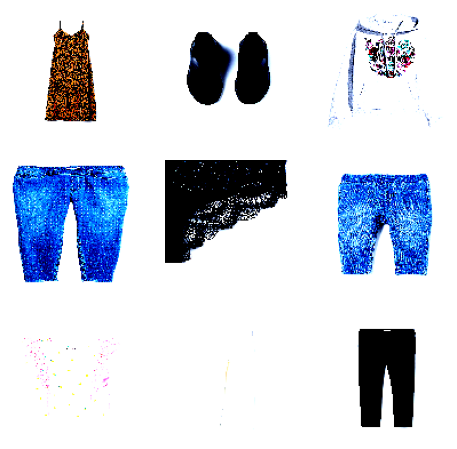

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img = dataset[sample_idx]['image']
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()

# Baseline Deep Model - Alexander

In [ ]:
!pip install torchtext

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [ ]:
from nltk.tokenize import word_tokenize
import torchtext.data

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import spacy

In [ ]:
spacy_en = spacy.load('en')
def tokenize_en(text):
  return [token.text for token in spacy_en.tokenizer(text)]

In [ ]:
def make_vocab_dataset(directory):
  # loads articles dataframe to get image descriptions from 
  articles = pd.read_csv(Config.base + 'articles.csv')

  # sets the primary index as the article id for optimized speed gains 
  articles = articles.set_index(['article_id'])
  articles["long_description"] = articles_nlp["long_description"]
  extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']
  images, captions = [], []
  _, class_to_idx = find_classes(directory)

  for target_class in sorted(class_to_idx.keys()):
      # class idx is supposed to be the class but we will redo this later 
      class_index = class_to_idx[target_class]
      target_dir = os.path.join(directory, target_class)
      if not os.path.isdir(target_dir):
          continue
      for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
          for fname in sorted(fnames):
              # get image path
              path = os.path.join(root, fname)

              # get text article id
              article_id = fname.split('.')[0]
              description = articles.loc[articles.index == int(article_id), "long_description"].values[0]

              # only add data if there exists a description i.e not empty
              if type(description) == str:
                captions.append(description)
                images.append(path)

  return captions 

In [ ]:
from torchtext.legacy import data

class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = row.sentiment if not is_test else None
            text = row.long_description
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, text_field, label_field, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)

        if train_df is not None:
            train_data = cls(train_df.copy(), text_field, label_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), text_field, label_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), text_field, label_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)
TEXT = data.Field()
vocab_dataset = DataFrameDataset.splits(
  text_field=TEXT, label_field=None, train_df=None, test_df = articles)[0]

In [ ]:
class BaseHMDataset(torch.utils.data.Dataset):
  def __init__(self, root, tokenizer, transforms):
    """
    There is a one to one correspondance between images and text.
    """
    self.images, self.captions = make_dataset(root)

    # tokenize the captions 
    self.encoded_captions = tokenizer(
            list(self.captions), padding=True, truncation=True, max_length=Config.max_length
        ) 

    self.transforms = transforms 

  def __getitem__(self, index):
    item = {
            key: torch.tensor(values[index])
            for key, values in self.encoded_captions.items()
        }

    image = self.images[index]
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      
    image = self.transforms(image=image)['image']
    item['image'] = torch.tensor(image).permute(2, 0, 1).float()
    item['caption'] = self.captions[index]

    return item 

  def __len__(self):
    return len(self.images)

In [ ]:
emb_dim = 300
words = []
idx = 0
word2idx = {}
vectors = []
with open('glove.6B.300d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect) # %s word vectors.' % len(embeddings_index))
vectors = np.array(vectors)
glove = {w: vectors[word2idx[w]] for w in words}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


In [ ]:
def vocab_tokenizer(inputs, padding, truncation, max_length, pad_index=0):
  out = {'tokens':[]}
  
  for input in inputs:
    input = tokenize_en(input)
    out['tokens'].append(input)
  return out

In [ ]:
vocab_iterator = data.Iterator(vocab_dataset,Config.batch_size)

In [ ]:
TEXT.build_vocab(vocab_dataset)

In [ ]:
target_vocab = TEXT.vocab.freqs.keys()

In [ ]:
matrix_len = len(target_vocab)
weights_matrix = np.zeros((matrix_len, 300))
words_found = 0
vocab2idx = {}
for i, word in enumerate(target_vocab):
    vocab2idx[word] = i
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))

In [ ]:
def baseline_tokenizer(inputs, padding='<pad>', truncation=True, max_length=Config.max_length, pad_index=0):
  out = {'ids':[],'mask':[]}
  
  for input in inputs:
    input = tokenize_en(input)
    if truncation:
      if len(input) > max_length:
        input = input[:max_length]
      elif len(input) < max_length:
        input += [padding] * (max_length-len(input))
    ids = torch.tensor([vocab2idx.get(word,0) for word in input])
    # out['tokens'] = input
    out['ids'].append(ids)
    out['mask'].append((ids != pad_index).unsqueeze(-2))
  return out

In [ ]:
transforms = get_transforms()
baseline_dataset = BaseHMDataset(
        Config.base + 'images/',
        tokenizer=baseline_tokenizer,
        transforms=transforms
    )

In [ ]:
len(baseline_dataset[1]['caption'])

In [ ]:
class BaselineImageEncoder(nn.Module):
  def __init__(self,encoding_dim=Config.base_image_embedding):
    super(BaselineImageEncoder,self).__init__()
    self.conv1 = nn.Conv2d(3,16,3, padding=1)
    self.conv2 = nn.Conv2d(16,32,3,padding=1)
    self.conv3 = nn.Conv2d(32,64,3,padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.fc = nn.Linear(14*14*64,encoding_dim)
  def forward(self,x):
    # print(x.shape)
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x).reshape(x.shape[0],-1)
    x = self.fc(x)
    # print(x.shape)
    return x

In [ ]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim
    

In [ ]:

class BaselineTextEncoder(nn.Module):
  def __init__(self,weights_matrix, input_size, hidden_size=Config.base_text_embedding, num_layers=1, dropout=0.):
      super(BaselineTextEncoder, self).__init__()
      self.num_layers = num_layers
      self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
      self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True, dropout=dropout)
        
  def forward(self, ids, mask, lengths=None):
      """
      Applies a bidirectional GRU to sequence of embeddings x.
      The input mini-batch x needs to be sorted by length.
      x should have dimensions [batch, time, dim].
      """
      x = self.embedding(ids)
      length = torch.tensor([Config.max_length]*x.shape[0])
      packed = pack_padded_sequence(x, length, batch_first=True)
      output, final = self.rnn(packed)
      output, _ = pad_packed_sequence(output, batch_first=True)

      # we need to manually concatenate the final states for both directions
      fwd_final = final[0:final.size(0):2]
      bwd_final = final[1:final.size(0):2]
      final = torch.cat([fwd_final, bwd_final], dim=2)  # [num_layers, batch, 2*dim]

      return final


In [ ]:
# Projection head serves to associate
# text and image vectors into the projection dimmension for comparison

class ProjectionHead(nn.Module):
  def __init__(self, embed_dim, project_dim=Config.projection_dim, dropout=Config.dropout):
    # embed dim is size of input vector 
    # Images are vectors of size 2048
    # Text is vectors of size 768 
    # Project dim is size of output vector (256)
    super().__init__()

    self.projection = nn.Linear(embed_dim, project_dim)

    # according to CLIP paper GELU performs better than ReLU
    self.activation = nn.GELU()

    self.fc = nn.Linear(project_dim, project_dim)

    # Use dropout to prevent overfitting
    self.dropout = nn.Dropout(dropout)

    # layernorm is preferred to batchnorm in NLP applications
    self.layer_norm = nn.LayerNorm(project_dim)
  
  def forward(self, x):
    projected = self.projection(x)
    x = self.activation(projected)
    x = self.fc(x)
    x = self.dropout(x)
    # introduce skip connection for faster training through backpropogation
    x = x + projected
    x = self.layer_norm(x)

    return x


In [ ]:
def contrastive_loss(text_embedding, image_embedding):
  # logit = torch.dot(text_embedding, image_embedding) / Config.temperature
  logit = (text_embedding @ torch.transpose(image_embedding,0,1)) / Config.temperature
  text_similarity = text_embedding @ text_embedding.T
  image_similarity = image_embedding @ image_embedding.T

  # get targets by averaging text and image similarity
  targets = F.softmax(
      (image_similarity + text_similarity) / 2 * Config.temperature,
      dim = 1
  )

  text_loss = cross_entropy(logit, targets)
  image_loss = cross_entropy(logit.T, targets.T)

  avg_loss = (text_loss + image_loss) / 2.0
  return avg_loss.mean()


def cross_entropy(pred, labels, reduction='none'):
  '''
  Define custom function since there is a potential for multiple captions per image
  '''

  log_softmax = nn.LogSoftmax(dim=-1)
  loss = (-labels * log_softmax(pred)).sum(1)

  if reduction == 'mean':
    loss = loss.mean()
  
  return loss 


In [ ]:
class BaselineCLIP(nn.Module):
  def __init__(self, weight_matrix, image_dim=Config.base_image_embedding, text_dim=Config.base_text_embedding*2, project_dim = Config.projection_dim):
    super().__init__()
    self.image_encoder = BaselineImageEncoder()
    self.text_encoder = BaselineTextEncoder(weight_matrix,input_size = emb_dim)
    self.image_projection = nn.Linear(image_dim, project_dim)
    self.text_projection = nn.Linear(text_dim, project_dim)

    # initialize both image and text projections using xavier 
    self.image_projection.apply(initialize_weights)
    self.text_projection.apply(initialize_weights)

  def forward(self, batch):
    # encode the image
    image_features = self.image_encoder(batch['image'])

    # encode the text
    text_features = self.text_encoder(
        ids=batch['ids'],
        mask=batch['mask'])
    
    image_embeddings = self.image_projection(image_features)
    text_embeddings = self.text_projection(text_features).squeeze()
    # print(image_embeddings.shape)
    # print(text_embeddings.shape)
    #calculate loss
    return contrastive_loss(image_embeddings, text_embeddings)

def initialize_weights(m):
  if isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [ ]:
class BaselineProjectionCLIP(nn.Module):
  def __init__(self, weight_matrix, image_dim=Config.base_image_embedding, text_dim=Config.base_text_embedding*2, project_dim = Config.projection_dim):
    super().__init__()
    self.image_encoder = BaselineImageEncoder()
    self.text_encoder = BaselineTextEncoder(weight_matrix,input_size = emb_dim)
    self.image_projection = ProjectionHead(embed_dim=image_dim)
    self.text_projection = ProjectionHead(embed_dim=text_dim)

    # initialize both image and text projections using xavier 
    self.image_projection.apply(initialize_weights)
    self.text_projection.apply(initialize_weights)

  def forward(self, batch):
    # encode the image
    image_features = self.image_encoder(batch['image'])

    # encode the text
    text_features = self.text_encoder(
        ids=batch['ids'],
        mask=batch['mask'])
    
    image_embeddings = self.image_projection(image_features)
    text_embeddings = self.text_projection(text_features).squeeze()
    # print(image_embeddings.shape)
    # print(text_embeddings.shape)
    #calculate loss
    return contrastive_loss(image_embeddings, text_embeddings)

def initialize_weights(m):
  if isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

# Training Baseline

*   Defining Metric Class
*   Defining Traning Code
*   Defining Validation Code 
*   Putting it all together and Executing



In [ ]:
import torchtext
import torchtext.vocab

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name

        # reinitalizes the avg, sum, and count
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    # updates the weight based on a new value, count pair
    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    # textual representation of the class 
    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text
    
    # float representation fo the class
    def get_loss(self):
      return self.avg

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [ ]:
def train_epoch(model, train_loader, optimizer):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    i = 0
    for batch in tqdm_object:
      i += 1
      batch = {k: v.to(Config.device) for k, v in batch.items() if k != "caption"}
      loss = model(batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      count = batch["image"].size(0)
      loss_meter.update(loss.item(), count)
      tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))

    return loss_meter

def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(Config.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

In [ ]:
train_size = int(0.8 * len(baseline_dataset))
valid_size = len(baseline_dataset) - train_size

# split full dataset into a training/test set with an 80/20 split
train_dataset, valid_dataset = torch.utils.data.random_split(
    baseline_dataset, [train_size, valid_size]
    )

indices = torch.randperm(len(train_dataset))
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dataset, indices),
    batch_size=Config.batch_size,
    num_workers=Config.num_workers,
)

indices = torch.randperm(len(valid_dataset))
valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(valid_dataset, indices),
    batch_size=Config.batch_size,
    num_workers=Config.num_workers,
)



In [ ]:
model = BaselineCLIP(torch.tensor(weights_matrix)).to(Config.device)
params = [
        {"params": model.image_encoder.parameters(), "lr": Config.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": Config.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": Config.head_lr, "weight_decay": Config.weight_decay}
    ]

optimizer = torch.optim.AdamW(params)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=Config.patience, factor=Config.factor
    )

# Todo cosine schedule optimizer

In [ ]:
def train_model(filename = 'best.pt'):
  step = 'batch'
  model = BaselineCLIP(torch.tensor(weights_matrix)).to(Config.device)
  params = [
        {"params": model.image_encoder.parameters(), "lr": Config.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": Config.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": Config.head_lr, "weight_decay": Config.weight_decay}
    ]

  optimizer = torch.optim.AdamW(params)
  lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=Config.patience, factor=Config.factor
    )

  train_losses = np.array([])
  valid_losses = np.array([])
  min_loss = float('inf')

  for epoch in range(Config.epochs):
    print(f"Epoch: {epoch + 1} \n")
    model.train()
    train_loss = train_epoch(model, train_loader, optimizer)
    print(f"Train Loss: {train_loss}")
    np.append(train_losses, train_loss.get_loss())

    model.eval()
    with torch.no_grad():
      valid_loss = valid_epoch(model, valid_loader)
      np.append(valid_losses, valid_loss.get_loss())

      if valid_loss.get_loss() < min_loss:
        torch.save(model.state_dict(), "best_base.pt")
        min_loss = valid_loss.get_loss()
    
    lr_scheduler.step(valid_loss.get_loss())
    print(f"Valid Loss: {valid_loss}")
    savetxt('train_losses.csv', train_losses, delimiter=',')
    savetxt('valid_losses.csv', valid_losses, delimiter=',')
  
  return train_losses, valid_losses 
  
train_losses, valid_losses = train_model()

In [ ]:
def train_base_projection_model():
  step = 'batch'
  model = BaselineProjectionCLIP(torch.tensor(weights_matrix)).to(Config.device)
  params = [
        {"params": model.image_encoder.parameters(), "lr": Config.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": Config.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": Config.head_lr, "weight_decay": Config.weight_decay}
    ]

  optimizer = torch.optim.AdamW(params)
  lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=Config.patience, factor=Config.factor
    )

  train_losses = np.array([])
  valid_losses = np.array([])
  min_loss = float('inf')

  for epoch in range(Config.epochs):
    print(f"Epoch: {epoch + 1} \n")
    model.train()
    train_loss = train_epoch(model, train_loader, optimizer)
    print(f"Train Loss: {train_loss}")
    np.append(train_losses, train_loss.get_loss())

    model.eval()
    with torch.no_grad():
      valid_loss = valid_epoch(model, valid_loader)
      np.append(valid_losses, valid_loss.get_loss())

      if valid_loss.get_loss() < min_loss:
        torch.save(model.state_dict(), "best_base_project.pt")
        min_loss = valid_loss.get_loss()
    
    lr_scheduler.step(valid_loss.get_loss())
    print(f"Valid Loss: {valid_loss}")
    savetxt('train_losses.csv', train_losses, delimiter=',')
    savetxt('valid_losses.csv', valid_losses, delimiter=',')
  
  return train_losses, valid_losses 
  
train_losses, valid_losses = train_base_projection_model()

In [ ]:
def plot_train_val(x, train, train_label, val=None, val_label=None, title=None):
  plt.plot(x, train, label=train_label)

  if val and val_label:
    plt.plot(x, val, label=val_label)
  plt.legend(loc='lower right')

  plt.xlabel('epoch')
  plt.ylabel('Contrastive Loss')
  plt.title(title)
  plt.show()

In [ ]:
print(train_losses)
print(valid_losses)
x = np.arange(0, len(train_losses))
plot_train_val(x,
               train_losses,
               train_label='Train Loss',
               val=valid_losses, 
               val_label='Validation Loss',
               title='CLIP Model Loss Per Epoch')

In [ ]:
# had to hard code model train/valid loss in case data was lost (it was in fact lost) since it takes so long to train
train_losses = [5.3628, 4.7316, 4.3595, 3.8062, 3.3061, 2.8674, 2.4778, 2.1402]
valid_losses = [4.8336, 4.7394, 4.1142, 3.5819, 3.2689, 3.0392, 2.9158, 2.9272]
x = np.arange(0, len(train_losses))
plot_train_val(x,
               train_losses,
               train_label='Train Loss',
               val=valid_losses, 
               val_label='Validation Loss',
               title='CLIP Model Loss Per Epoch')

In [ ]:
def get_image_embeddings(data, model):
  embeddings = []

  model.eval()

  # makes model weights non trainable
  with torch.no_grad():
    for batch in tqdm(data):
      # encode + project images 
      image_features = model.image_encoder(batch["image"].to(Config.device))
      image_embeddings = model.image_projection(image_features)
      embeddings.append(image_embeddings)
  
  return torch.cat(embeddings)

In [ ]:
def find_base_matches(model, image_embeddings, image_filenames, query, n=1):

  # tokenize query 
    encoded_query = baseline_tokenizer([query])
    # print(encoded_query)
    batch = {
        key: torch.tensor(values[0]).unsqueeze(0).to(Config.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():

      # get text features + projection 
        text_features = model.text_encoder(
        ids=batch['ids'],
        mask=batch['mask'])
        text_embeddings = model.text_projection(text_features)
    
    # use contrastive loss to find closest matches 
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n)
    matches = [image_filenames[idx] for idx in indices]
    
    i = 1
    
    image = cv2.imread(matches[0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f'Match: {i}')
    
    plt.show()

In [ ]:
model = model = BaselineProjectionCLIP(torch.tensor(weights_matrix)).to(Config.device)
model.load_state_dict(torch.load('best_base_project.pt'))
model.eval()
image_embeddings = get_image_embeddings(valid_loader, model)

  0%|          | 0/165 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


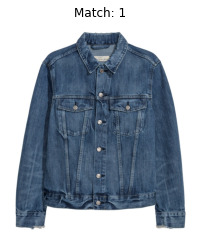

In [ ]:
find_base_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Blue jeans with rips',
             n=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


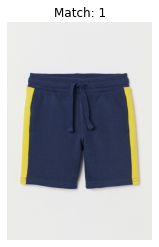

In [ ]:
find_base_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Green Hoodie with letters on front',
             n=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


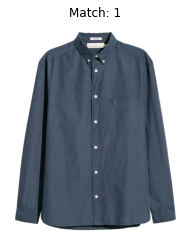

In [ ]:
find_base_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Short, green t-shirt with front pocket',
             n=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


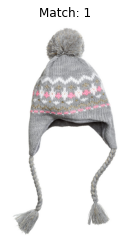

In [ ]:
find_base_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Short sleeved, white shirt',
             n=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


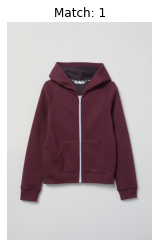

In [ ]:
find_base_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Long, brown, Fleece turtleneck',
             n=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


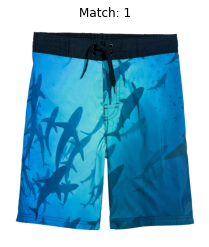

In [ ]:
find_base_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Childrens matching pajamas',
             n=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


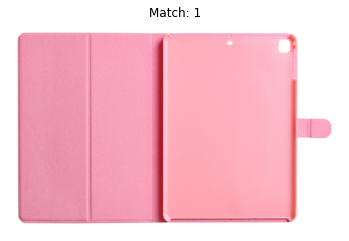

In [ ]:
find_base_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Long Orange chino pants',
             n=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


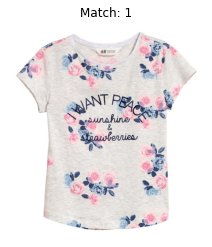

In [ ]:
find_base_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='White bra',
             n=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


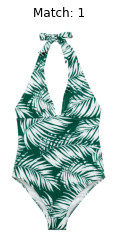

In [ ]:
find_base_matches(model,
             image_embeddings,
             image_filenames=valid_dataset.dataset.images,
             query='Black beanie with no text',
             n=1)